<a href="https://colab.research.google.com/github/axellee1994/Dog_Vision_CV/blob/main/Dog_Vision_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification

This notebook build an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

## 1.Problem

Identifying the breed of a dog given an image of a dog.

## 2.Data

The data used is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/overview

## 3.Evaluation

Evaluation is a file with prediction probabilitirs for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview

## 4.Features

Some information about the data:
* Dealing with images (unstructred data) so it's best to use deep learning/transfer learning
* 120 breeds of dogs (this means there are 120 different classes)
* There are around 10,000+ images in the training set (These have labels)
* There are around 10,000+ images in the test set (These have no labels, because we will want to predict them)


## Getting workspace ready
* Import TensorFlow 2.X
* Import TensorFlow Hub
* Make sure this is using a GPU

In [1]:
# Unzip the uploaded data into Google Drive
from google.colab import drive
drive.mount('/content/drive')

# !unzip "drive/MyDrive/Dog_Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog_Vision"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.19.0
Hub version: 0.16.1


In [3]:
# # If Tensorflow is under 2.X
# try:
#   # %tensorflow_version only exists in Colab
#   %tensorflow_version 2.x
# except Exception:
#     pass
# print ("TensorFlow Version: ", tf.__version__)

In [4]:
# Check for GPU availability
# Click Runtime -> Change runtime type -> Select GPU

physical_devices = tf.config.list_physical_devices('GPU')
print("GPU:",physical_devices)
print("Number of GPU:", len(physical_devices))

GPU: []
Number of GPU: 0


# Preparing The Images

Getting our data ready (Turning into Tensors)

With all machine learning models, out data has to be in numerical format.
Turning our images into Tensors(numerical differences)

In [5]:
# Checkout labels of our data

import pandas as pd

labels_csv = pd.read_csv("/content/drive/MyDrive/Dog_Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head(5))

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: xlabel='breed'>

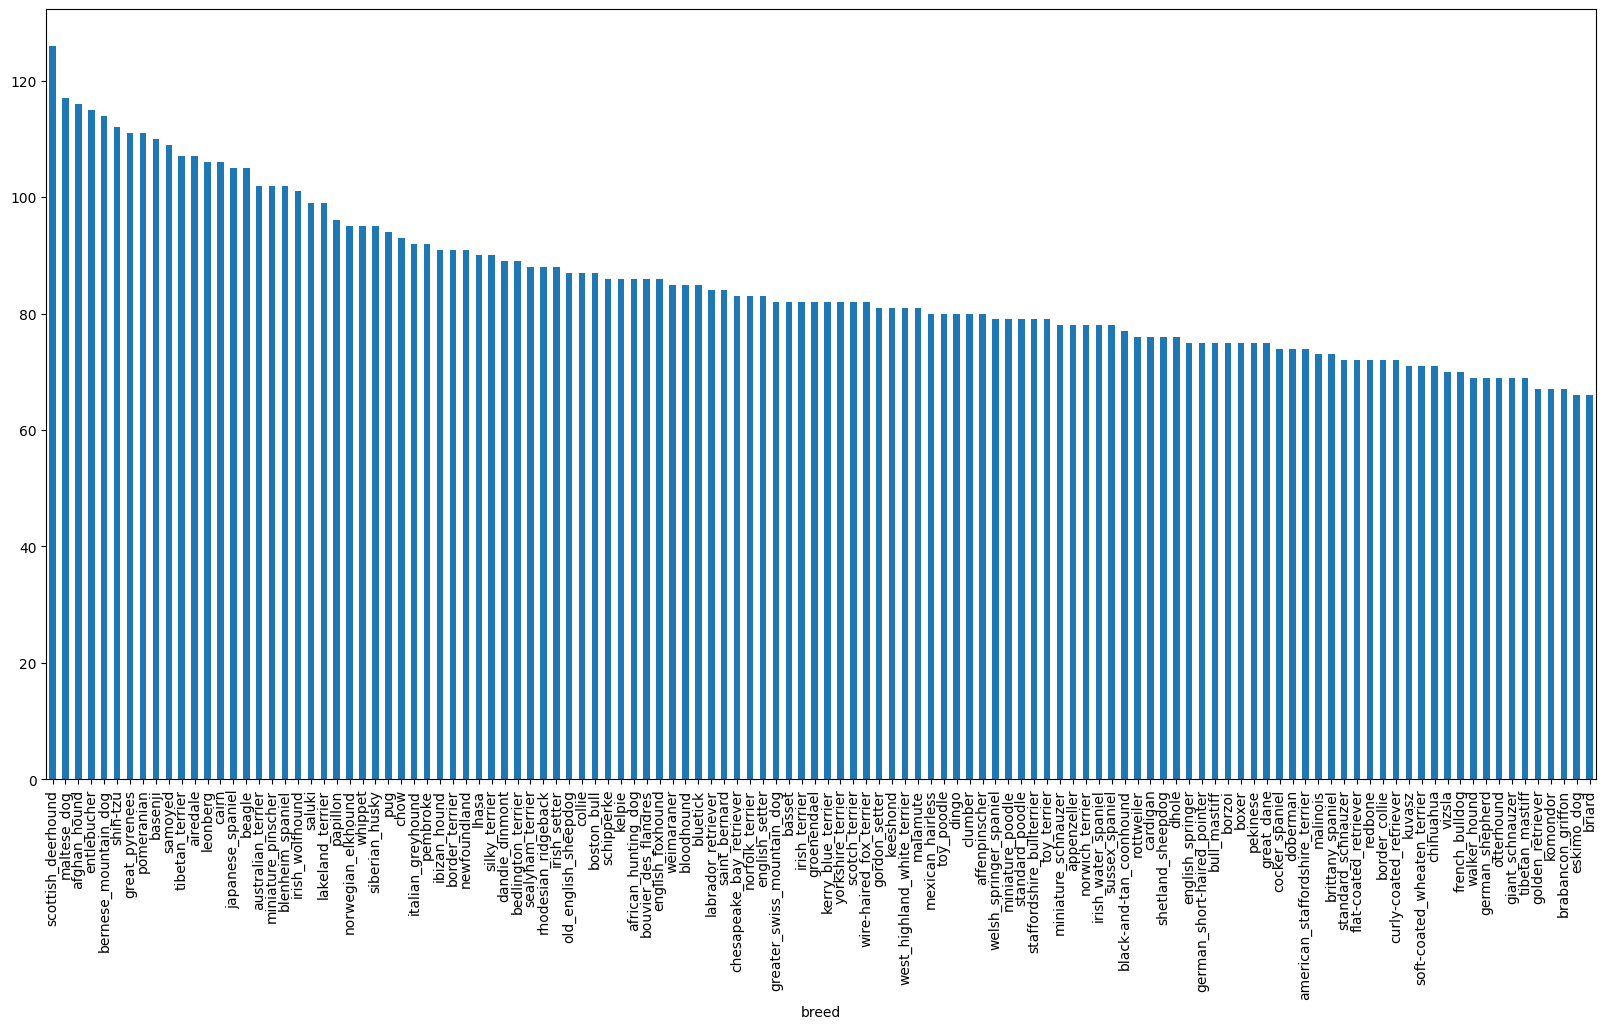

In [6]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [7]:
# Average number of photos in the training set
labels_csv["breed"].value_counts().median()

82.0

In [8]:
# Google recommends about 1000 training images per label.
# Minimum is about 10 per label

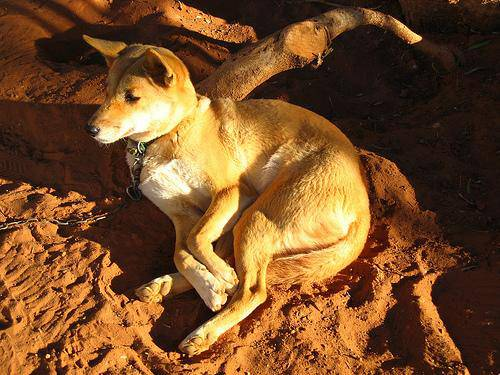

In [9]:
# Viewing an image

from IPython.display import Image
Image("drive/MyDrive/Dog_Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

. A list of all of the image file pathnames

In [10]:
#Create pathnames from Image ID's

base_path = "drive/MyDrive/Dog_Vision/train/"

image_id = []
for i in labels_csv["id"]:
  image_id.append(i)

file_extension = ".jpg"

filenames = []
for i in range(len(labels_csv)):
  filenames.append(f"{base_path}{image_id[i]}{file_extension}")

# Another way of doing it -> filenames = ["drive/MyDrive/Dog_Vision/train" + fname + ".jpg" for fname in labels_csv[id]]

# Check number of filenames is the same as the number of files in the folder train
import os

if len(os.listdir("drive/MyDrive/Dog_Vision/train/")) == len(filenames):
  print("Same length")
else:
  print("Different length")

Same length


In [11]:
# Check that one image is printed correctly

Image(filenames[0])
print(labels_csv["breed"][0])

boston_bull


Since we have now gotten the training image filepaths in a list. time to prepare for the labels

In [12]:
import numpy as np

# Another method labels = labels_csv["breed"].to_numpy()
labels = labels_csv["breed"].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [13]:
# Check for missing data
# In unstructured data, harder to check for missing data -> use len(labels) to match the amount of filenames to see for missing data

if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories")


Number of labels matches number of filenames


In [14]:
# Find the unique label values

unique_breeds = np.unique(labels)
print(unique_breeds)

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'italian

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array

boolean_labels = [label == np.array(unique_breeds) for label in labels]
print(boolean_labels[:2])

[array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False]), array([False, False, False, False, False, False, False, Fal

In [17]:
print(len(boolean_labels))

10222


In [18]:
# Example: Turning boolean array into integers

print(labels[0])
print(np.where(unique_breeds == labels[0])) #Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating out own validation set

Since the dataset from Kaggle doesn't come with a validation set, I will be creating on my own

In [19]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [20]:
len(filenames)

10222

Test on a small sample size first (1000) before increasing as I needed


In [21]:
# Set number of images to use for experimenting
NUM_IMAGES = 2000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [22]:
# Create training and validation set
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size of NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(1600, 400, 1600, 400)

In [23]:
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog_Vision/train/17c5e8815cf0d086090a07b003b9b036.jpg',
  'drive/MyDrive/Dog_Vision/train/0593e37870ee77b0d34508e118bf6670.jpg',
  'drive/MyDrive/Dog_Vision/train/1428026a4472cda58ad13233bb9ad64d.jpg',
  'drive/MyDrive/Dog_Vision/train/10f1d53bb20d5acc7c8772018399c238.jpg',
  'drive/MyDrive/Dog_Vision/train/0a1b0b7df2918d543347050ad8b16051.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing images into tensors

**`Things to do`**:
> 1. Take a `Image` filename as input.
2. Use TensorFlow to read the file and save it to a variable.
3. Turn the `Image` into Tensor.
4. Normalize color channel(turn the value from 0-225, to 0-1)
5. Resize the `Image` to shape (224, 224)
6. Return the modified `Image`

In [24]:
from matplotlib.pyplot import imread
image = imread(filenames[42]) # Reading an image
image.shape # Height, Width, Color Channel

(257, 350, 3)

In [25]:
# Custom Function to process images
# 224 is the standard, good computation efficienc
IMAGE_SIZE = 224

def get_image(filepath, image_size=IMAGE_SIZE):
  # Read the filepath
  image = tf.io.read_file(filepath)

  # Split it into 3 channels
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert them from 255 RGB values to [0,1]
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize them to 224
  image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
  print(f"Resize image shape: {image.shape}")

  return image
get_image(filenames[2])

Resize image shape: (224, 224, 3)


<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3918853 , 0.3918853 , 0.36051273],
        [0.43775532, 0.43775532, 0.40638277],
        [0.44351017, 0.44351017, 0.41213763],
        ...,
        [0.05796662, 0.02239764, 0.01937653],
        [0.05252095, 0.0470589 , 0.04978992],
        [0.04586835, 0.05371149, 0.04978992]],

       [[0.38653433, 0.38261276, 0.3630049 ],
        [0.4161569 , 0.41223532, 0.39262748],
        [0.43315482, 0.42923325, 0.4096254 ],
        ...,
        [0.0909924 , 0.05177672, 0.04754004],
        [0.03035708, 0.02489503, 0.02762605],
        [0.02370449, 0.03154762, 0.02762605]],

       [[0.36859888, 0.3646773 , 0.34506944],
        [0.35422263, 0.35030106, 0.33069322],
        [0.39899355, 0.39507198, 0.3754641 ],
        ...,
        [0.2361781 , 0.20233706, 0.19541305],
        [0.04896353, 0.04268564, 0.04582458],
        [0.04459034, 0.04705883, 0.04582458]],

       ...,

       [[0.7591447 , 0.75522316, 0.7356153 ],
        [0.74

TensorFlow needs to use Tensor tuples, will need to create a function to return tuples.

In [26]:
def get_image_label(filepath, label):
  image = get_image(filepath)
  return image, label

In [27]:
# Testing out function
get_image_label(filenames[42], boolean_labels[42])

Resize image shape: (224, 224, 3)


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Since there is now a way to turn data into tuples of tensors in the form of "(image, label)", need to create a function to turn all of data (X & y) into batches

In [28]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Function for augmentation
def augment_image(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.central_crop(image, 0.5)
  return image, label

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(get_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data = data.map(augment_image)
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [29]:
# Create training and validation data batches
train_dataset = create_data_batches(X_train, y_train)
val_dataset = create_data_batches(X_val, y_val)

Creating training data batches...
Resize image shape: (224, 224, 3)
Creating training data batches...
Resize image shape: (224, 224, 3)


In [30]:
train_dataset.element_spec, val_dataset.element_spec

((TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Data is now in batches, better to visualize it

In [31]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  #Plot the figure
  plt.figure(figsize=(10,10))

  # Loop through 25 images and print them all out:
  for i in range(25):
    # Create subplots of 5 rows and 5 cols
    ax = plt.subplot(5,5, i+1)
    # Display the image
    ax.imshow(images[i])

    # Add image label as the title
    ax.set_title(unique_breeds[labels[i].argmax()])

    # Turn grid lines off
    ax.axis("off")

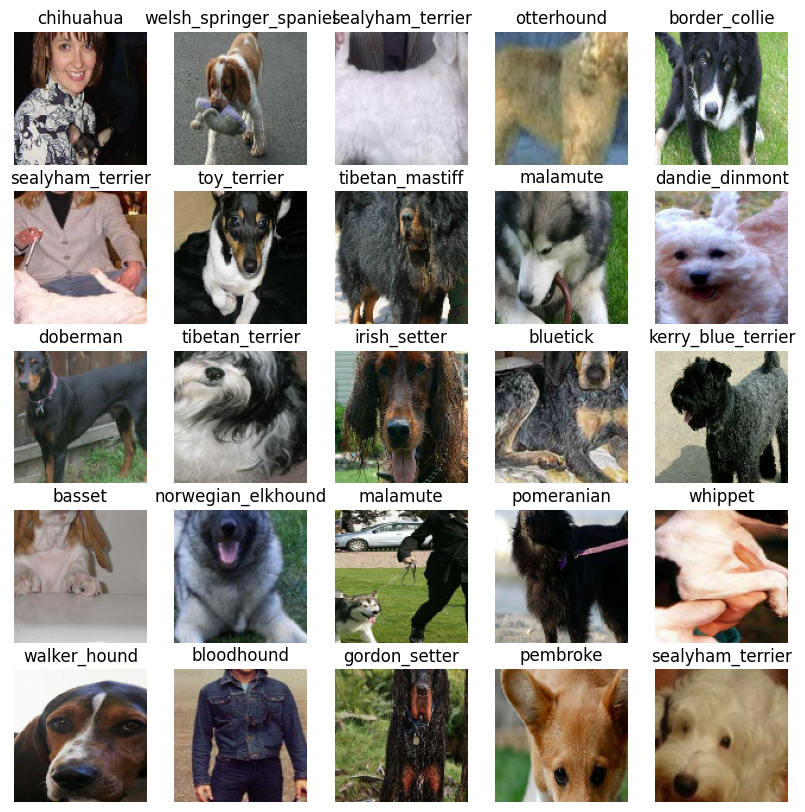

In [32]:
# To make computation efficient, a batch is a tightly wound collection of Tensor
# To view the data, need to undwind it with as_numpy_iterator() method on data batch
# Turns the data batch into something that can be iterated over. Passing an interabel
# (next) will return the new iterm in the iterator

train_images, train_labels = next(train_dataset.as_numpy_iterator())
show_25_images(train_images, train_labels)

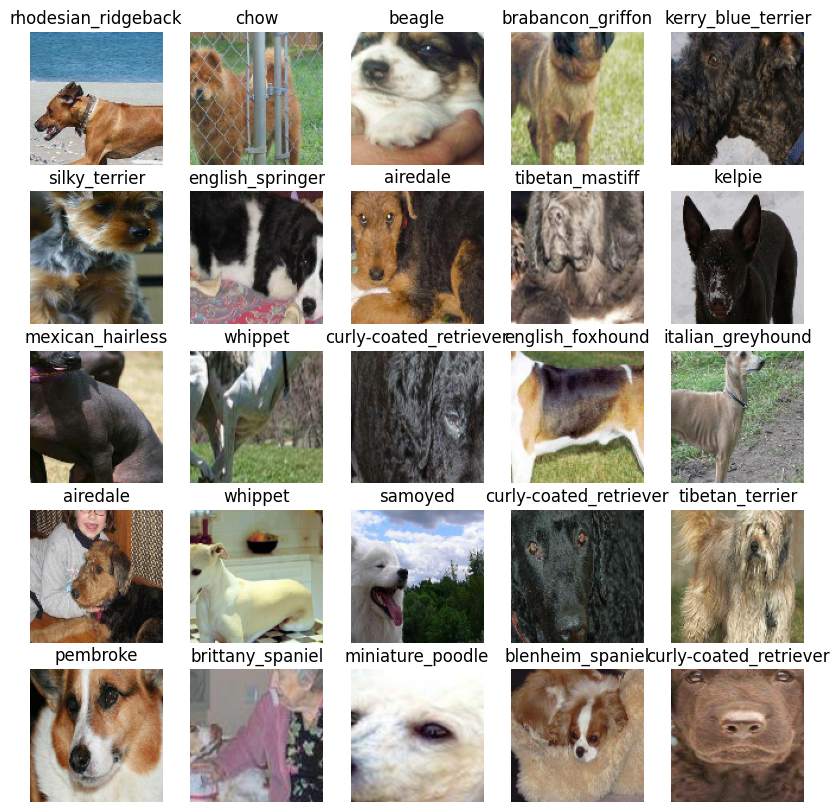

In [33]:
# Do the same for validation

val_images, val_labels = next(val_dataset.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Preparing Inputs and Outputs

##  Building a model

Before building a model, there are a few things need to define:
* The input shape (image shape in the form of Tensors) to our model
* The outshape( image labels, in the form of tensors) of our model
* URL of the model we want to use - https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification

In [34]:
# Set up input shape to the model
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # Batch, Height, Width, Colour Channels

# Set up output shape of our model size
OUTPUT_SHAPE = len(unique_breeds)

Create a function which:
* Takes the input shape, output shape and the model chosen as parameters
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (Shouls be evaluated and improved)
* Builds the model (Tell the model the input shape it will be getting)
* Returns the model

In [35]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    print("Building model with MobileNetV2 (Sequential)")
    model = tf.keras.Sequential([
        tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3)),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=output_shape, activation="softmax")
    ])
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [36]:
model = create_model(INPUT_SHAPE)
model.summary()

Building model with MobileNetV2 (Sequential)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 2,377,592 (9.07 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [37]:
%load_ext tensorboard

# Creating callbacks

Callbacks are helper functions a model ca use during training to do thinggs such as save a model check amodel progress or stop training early if a model stops improving

The two callbacks I will be using will be a TensorBoard callback and an Early Stopping Callback

### TensorBoard Callback

Good way of monitoring the progress during and after the training visually

Can use it directly in a notebook to track performacne measures of model

1. Load the TensorBoard Notebook Extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to model fit function
3. Visualize the more training logs using the %tensorboard magic function

## Early Stopping Callback

Prevents overfititng by stopping a model when a certain evaluation metric stops improving.

If a model trains for too long, will be able to find patterns in a certain dataset that it's not able to use those patterns on another dataset

In [38]:
# Load the TensorBoard Notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
import datetime, os
import keras

In [40]:
def tensorboard_callback():
  # Create a log directory for storing TensorBoard Logs
  # Make it so the logs get tracked whenever we run an experiemnt
  logdir = os.path.join("drive/MyDrive/Dog_Vision/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

  return tensorboard_callback

In [41]:
# Patience 3 = Try 3 times else stop the training

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=3)

# Training a model (on subset of data)

First model will be trained on 1000 images (800 trained/ 200 validation)

Just doing this to make sure everything is working. If so, will use the whole image and train on the entire testing set

NUM_EPOCHS defines how many passes of data we like the model to do (How many rounds). A pass is equivalent to the model trying to find patterns in each dog image and see which pattenrs relate to each label

If NUM_EPOCH=1, model will only look at the data once. Best to set either 10 - 100 as a starting point

In [42]:
# Set number of rounds a model should view
NUM_EPOCH = 100 #@param {type: "slider", min:10, max:100, step:1}



*   Create a model using create_model()
*   Set up Tensorboard callback using create_tensorboard_callback()
* Call the fit function on model, passing the training data, validation data and epochs to train and callbacks to use
* Return the fitted model


In [43]:
def train_model():
  #Instantiate the model
  model = create_model()

  # Create the Tensorboard session everytime a model is trained
  tensorboard = tensorboard_callback()

  # Fit the model to the data passing
  model.fit(x=train_dataset,
            epochs=NUM_EPOCH,
            callbacks=[tensorboard, early_stopping_callback],
            validation_data=val_dataset,
            validation_freq=2,)
  return model

# Starting training the model
model = train_model()

Building model with MobileNetV2 (Sequential)
Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "mobilenetv2_1.00_224" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 112, 112, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 112, 112, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

Model looks like it is overfitting (1.0 on the training set but low score on the validation). Need to think of some way to prevent overfitting in this. At the moment, this is overfitting due to the small sample size

Thought overfitting at the start is good, means that the model is learning something

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog_Vision/logs

Model stops around 60+ Epoch after looking at in 25 batches of 32 image per batch size (800 pictures on training set)

Validation accuracy failed to improved for 3 epoch, accuracy got to 40% in a few minutes.

# Making and evaluating predictions using a trained model

In [ ]:
predictions = model.predict(val_dataset, verbose=1)
predictions

In [ ]:
predictions.shape

This returns an array(predictions) of arrays, each containing 120 different values (one for each unique dog breed)

The higher the value, the more likely the model things a given image is a specific breed of dog

In [ ]:
# First prediction
index = 0

print(predictions[0])
print(f"Max value(probability of prediction/confidence interval): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

In [ ]:
## Function to convert prediction probabilities into predicted labels

def get_pred_label(prediction_probabilities):
  return unique_breeds[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[0])
pred_label

Because the validation data (val data) is in batch form, to get a list of validation images and labels, will need to unbatch it (using unbatch()) and then turn it into an interator using as_numpy_iterator()

In [ ]:
def unbatching(data):
  """
  Takes a batched dataset of (image, label) Tensors and spearate array of images and labels
  """

  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

val_images, val_labels = unbatching(val_dataset)
val_images[0], val_labels[0]


# Visualizing the Model Predictions

Should be able to view the image, predicted label and the actual label.

Create a function that will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer
* Convert the prediction probabilities to a predicted label
* Plot the predicted label, predicted probability, the truth label and the target image on a single plot

In [ ]:
def plot_pred(prediction_probabilities, labels, images,):
  """
  View the prediction, ground truth label and image for sample n
  """
  n = 1
  pred_prob = prediction_probabilities[n]
  true_label = labels[n]
  images = images[n]

  # Get the prediction label):
  pred_label = get_pred_label(pred_prob)

  # Change the colour of the title depending if the prediction is correct or incorrect
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Plot images and remove ticks
  plt.imshow(images)
  plt.xticks([])
  plt.yticks([])

  #Plot the title
  plt.title(f"Prediction: {pred_label},\n Probability: {pred_prob[np.argmax(pred_prob)]:2.0f}:,\n Actual: {true_label}",
            color=color)

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)